In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [2]:
import torch
import torchtuples as tt

In [3]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [5]:
df_train = metabric.read_df()

In [6]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [10]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [11]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

In [12]:
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [13]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [14]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [15]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [16]:
labtrans.cuts

array([  0.      ,  39.466667,  78.933334, 118.4     , 157.86667 ,
       197.33334 , 236.8     , 276.26666 , 315.73334 , 355.2     ],
      dtype=float32)

In [17]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [19]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [20]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [21]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 2.9304,	val_loss: 2.7584
1:	[0s / 2s],		train_loss: 2.6377,	val_loss: 2.5098
2:	[0s / 2s],		train_loss: 2.3823,	val_loss: 2.1982
3:	[1s / 4s],		train_loss: 2.0549,	val_loss: 1.8769
4:	[0s / 4s],		train_loss: 1.7473,	val_loss: 1.5989
5:	[0s / 5s],		train_loss: 1.5546,	val_loss: 1.4458
6:	[0s / 6s],		train_loss: 1.4439,	val_loss: 1.3886
7:	[0s / 7s],		train_loss: 1.3967,	val_loss: 1.3791
8:	[0s / 8s],		train_loss: 1.3980,	val_loss: 1.3661
9:	[0s / 8s],		train_loss: 1.3644,	val_loss: 1.3582
10:	[0s / 9s],		train_loss: 1.3499,	val_loss: 1.3583
11:	[0s / 10s],		train_loss: 1.3424,	val_loss: 1.3571
12:	[0s / 11s],		train_loss: 1.3310,	val_loss: 1.3573
13:	[0s / 11s],		train_loss: 1.3130,	val_loss: 1.3586
14:	[0s / 12s],		train_loss: 1.3271,	val_loss: 1.3630
15:	[0s / 13s],		train_loss: 1.3195,	val_loss: 1.3585
16:	[0s / 13s],		train_loss: 1.3003,	val_loss: 1.3644
17:	[0s / 14s],		train_loss: 1.3081,	val_loss: 1.3698
18:	[0s / 15s],		train_loss: 1.2980,	val_loss: 1.

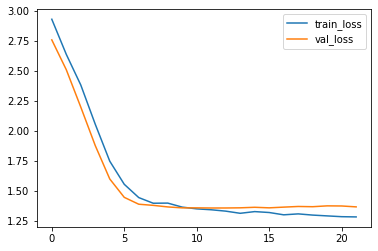

In [22]:
_ = log.plot()

In [23]:
log.to_pandas().val_loss.min()

1.3570786714553833

In [24]:
model.score_in_batches(val)

{'loss': 1.3570786714553833}

In [25]:
surv = model.predict_surv_df(x_test)

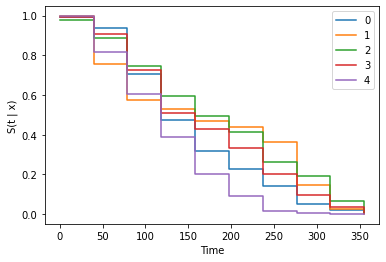

In [26]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [27]:
surv = model.interpolate(10).predict_surv_df(x_test)

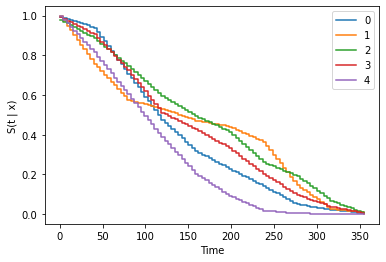

In [28]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [29]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [30]:
ev.concordance_td('antolini')

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 7000. The TBB threading layer is disabled.
  warnings.warn(problem)


0.6521683835686125

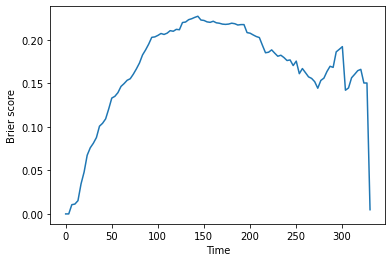

In [31]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

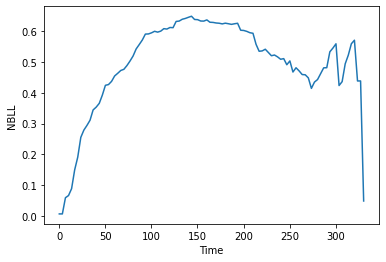

In [32]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [33]:
ev.integrated_brier_score(time_grid) 

0.16752534368608704

In [34]:
ev.integrated_nbll(time_grid) 

0.49653504784798114